In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pprint
import math

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rc('legend', fontsize=16)
plt.rcParams.update({'font.family': 'Times New Roman'})

In [3]:
data = []
results_dir = "results"
files = [f for f in os.listdir(results_dir) if os.path.isfile(os.path.join(results_dir, f))]
n_lists = []
delays = {
    "Standard": [],
    "Corrected": [],
    "CorrectedML": [],
}

for file in files:
    with open(os.path.join(results_dir, file), "r") as f:
        lines = [line.rstrip() for line in f]
        headers = lines[0].split(",")
        
        duration = int(lines[5].split(",")[1]) / 1000  # duration in seconds
        n_list = [int(x) for x in lines[6].split(",")[1][:-1].split(":")]
        n_lists.append(n_list)
        
        for line in lines[7:10]:
            parts = line.split(",")
            delays[parts[0]].append([int(x) for x in parts[1][:-1].split(":")])
        
        sim_run = {}
        for line in lines[1:4]:
            parts = line.split(",")
            sim_run[parts[0]] = {
                headers[1]: int(parts[1]),
                headers[2]: int(parts[2]),
                headers[3]: int(parts[3]),
                headers[4]: int(parts[4]),
            }
        
        data.append(sim_run)


print(duration)
# print(delays)
print(data)

metrics = {name: {
    "Throughput": [],
    "Energy Consumption": [],
    "Energy Efficiency": [],
    "Energy Consumption Sender": [],
    "Energy Efficiency Sender": [],
    "Energy Consumption Receiver": [],
    "Energy Efficiency Receiver": [],
    "Percent of Errors Corrected": [],
    "Delay": [],
} for name in data[0].keys()}
print(metrics)

for index, sim_run in enumerate(data):
    for key in metrics.keys():
        metrics[key]["Throughput"].append(sim_run[key]["frameDisplayed"] / duration)
        metrics[key]["Percent of Errors Corrected"].append(1 - (sim_run[key]["errorCountAC"] / sim_run[key]["errorCountBC"]))
        
        baseline_receiver = 0.01  # J, not watts since we assume a constant time for receiving and sender regardless of the size of the packet
        baseline_sender =   0.01  # J
        p_cycle_node = 0.0000082  # J
        p_cycle_sat =  0.0000082  # J

        if key == "Standard":
            ec = (baseline_sender * sim_run[key]["frameCount"]) + (baseline_receiver * sim_run[key]["frameCount"])
            ec_s = (baseline_sender * sim_run[key]["frameCount"])
            ec_r = (baseline_receiver * sim_run[key]["frameCount"])
        elif key == "Corrected":
            n = 22
            k = 18
            M = math.ceil(18 / k)

            # These are the iterations
            iter_encoding = M * k * (n - k)
            iter_decoding = M * n * (n - k)

            e_encoding = iter_encoding * p_cycle_node
            e_decoding = iter_decoding * p_cycle_sat
            ec = (baseline_sender * sim_run[key]["frameCount"]) + (baseline_receiver * sim_run[key]["frameCount"]) + (e_encoding * sim_run[key]["frameCount"]) + (e_decoding * sim_run[key]["frameCount"])
            
            ec_s = (baseline_sender * sim_run[key]["frameCount"]) + (e_encoding * sim_run[key]["frameCount"])
            ec_r = (baseline_receiver * sim_run[key]["frameCount"]) + (e_decoding * sim_run[key]["frameCount"])
        elif key == "CorrectedML":
            ec = 0
            ec_s = 0
            ec_r = 0
            for n in n_lists[index]:
                k = 18
                M = math.ceil(18 / k)

                # These are the iterations
                iter_encoding = M * k * (n - k)
                iter_decoding = M * n * (n - k)

                e_encoding = iter_encoding * p_cycle_node
                e_decoding = iter_decoding * p_cycle_sat
                ec += baseline_sender + baseline_receiver + e_encoding + e_decoding
                ec_s += baseline_sender + e_encoding
                ec_r += baseline_receiver + e_decoding
                
        metrics[key]["Energy Consumption"].append(ec)
        metrics[key]["Energy Consumption Sender"].append(ec_s)
        metrics[key]["Energy Consumption Receiver"].append(ec_r)
        
        metrics[key]["Energy Efficiency"].append(sim_run[key]["frameDisplayed"] / ec)
        metrics[key]["Energy Efficiency Sender"].append(sim_run[key]["frameDisplayed"] / ec_s)
        metrics[key]["Energy Efficiency Receiver"].append(sim_run[key]["frameDisplayed"] / ec_r)
        
        metrics[key]["Delay"].append(sum(delays[key][index]) / len(delays[key][index]))


pprint.pprint(metrics)

30.0
[{'Standard': {'frameCount': 900, 'frameDisplayed': 309, 'errorCountBC': 591, 'errorCountAC': 591}, 'Corrected': {'frameCount': 900, 'frameDisplayed': 300, 'errorCountBC': 737, 'errorCountAC': 600}, 'CorrectedML': {'frameCount': 900, 'frameDisplayed': 613, 'errorCountBC': 690, 'errorCountAC': 287}}, {'Standard': {'frameCount': 900, 'frameDisplayed': 275, 'errorCountBC': 625, 'errorCountAC': 625}, 'Corrected': {'frameCount': 900, 'frameDisplayed': 335, 'errorCountBC': 705, 'errorCountAC': 565}, 'CorrectedML': {'frameCount': 900, 'frameDisplayed': 596, 'errorCountBC': 668, 'errorCountAC': 305}}, {'Standard': {'frameCount': 901, 'frameDisplayed': 162, 'errorCountBC': 739, 'errorCountAC': 739}, 'Corrected': {'frameCount': 901, 'frameDisplayed': 440, 'errorCountBC': 650, 'errorCountAC': 461}, 'CorrectedML': {'frameCount': 900, 'frameDisplayed': 563, 'errorCountBC': 746, 'errorCountAC': 337}}, {'Standard': {'frameCount': 901, 'frameDisplayed': 203, 'errorCountBC': 698, 'errorCountAC': 6

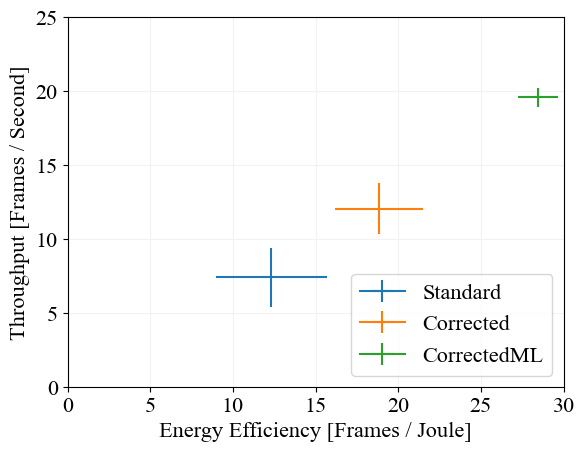

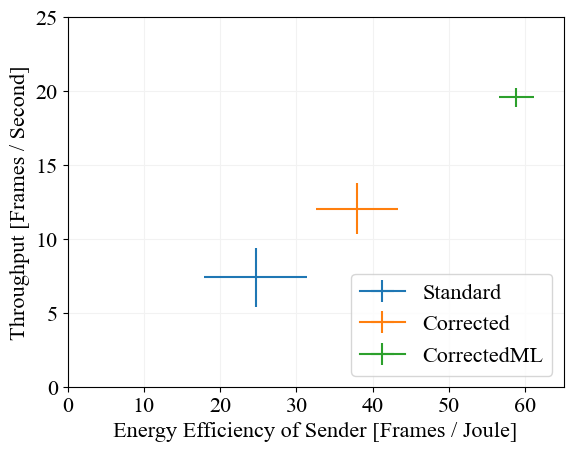

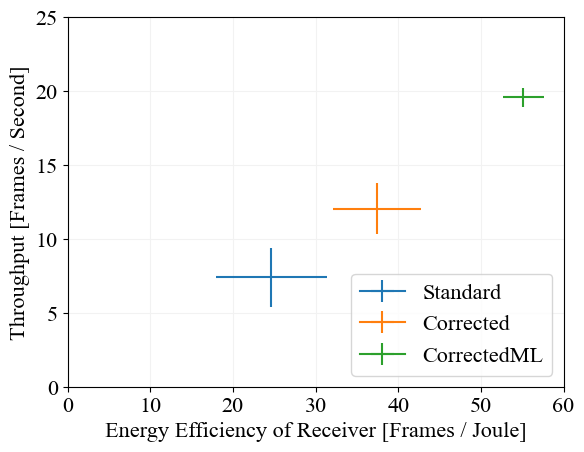

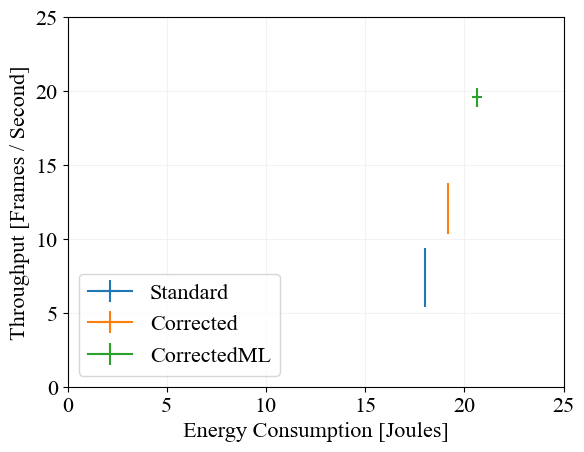

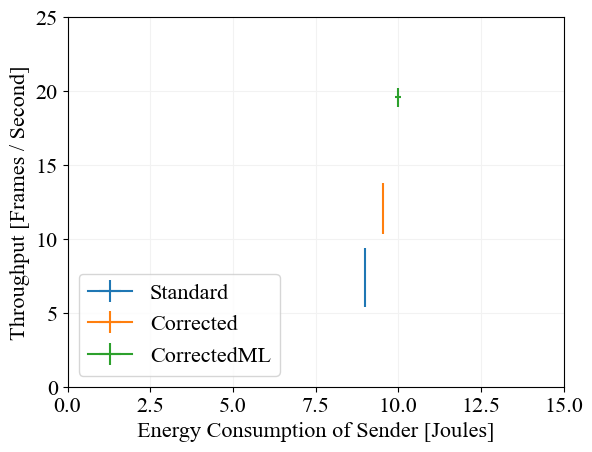

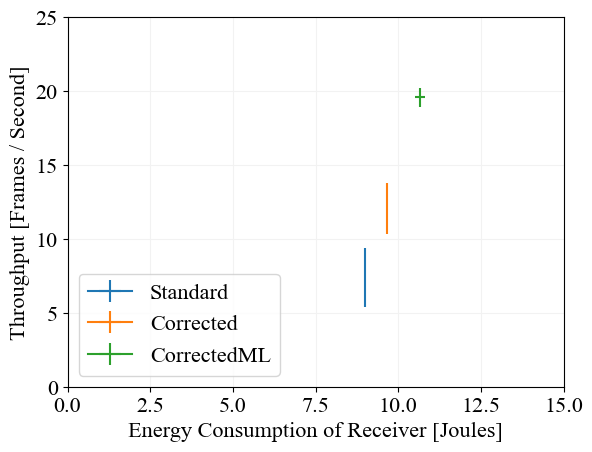

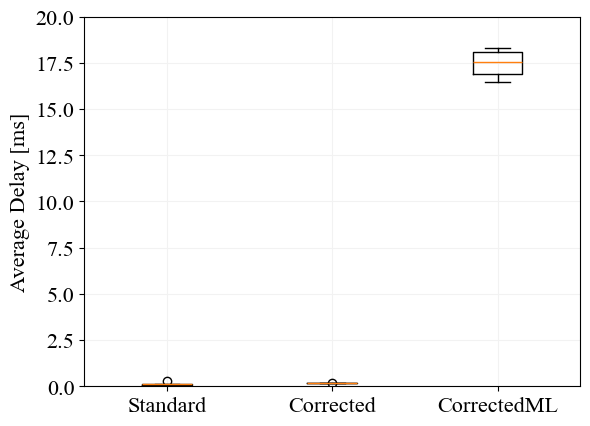

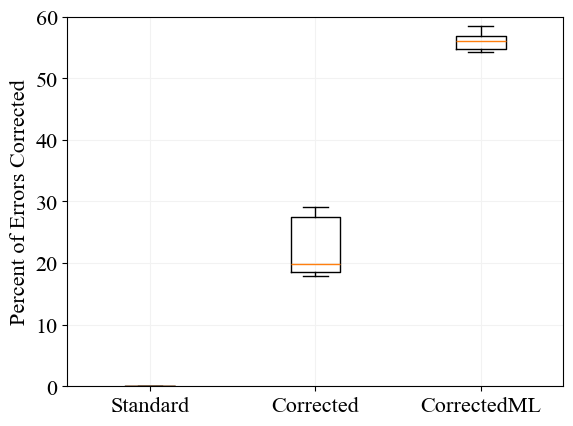

In [8]:
output_dir = "output_graphs"

def plot_graph(metric1, metric2, y_label, x_label, y_max, x_max):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for name in metrics.keys():
        xs = metrics[name][metric1]
        x = np.average(xs)
        xerr = np.std(xs)
        ys = metrics[name][metric2]
        y = np.average(ys)
        yerr = np.std(ys)

        plt.errorbar([x], [y], xerr=[xerr], yerr=[yerr], label=name)

    plt.ylabel(y_label)
    plt.xlabel(x_label)
    if "Energy Consumption" in metric1:
        plt.legend(loc="lower left", numpoints=1)
    else:
        plt.legend(loc="lower right", numpoints=1)
    plt.grid(linestyle='-', color='0.95')

    plt.ylim(0, y_max)
    plt.xlim(0, x_max)

    plt.savefig(
        os.path.join(output_dir, f"{(x_label + y_label).replace(' ', '_').replace('/', '_')}.pdf"),
        format="pdf"
    )
    plt.show()


plot_graph(
    "Energy Efficiency",
    "Throughput",
    "Throughput [Frames / Second]",
    "Energy Efficiency [Frames / Joule]",
    25,
    30,
)

plot_graph(
    "Energy Efficiency Sender",
    "Throughput",
    "Throughput [Frames / Second]",
    "Energy Efficiency of Sender [Frames / Joule]",
    25,
    65,
)

plot_graph(
    "Energy Efficiency Receiver",
    "Throughput",
    "Throughput [Frames / Second]",
    "Energy Efficiency of Receiver [Frames / Joule]",
    25,
    60,
)

plot_graph(
    "Energy Consumption",
    "Throughput",
    "Throughput [Frames / Second]",
    "Energy Consumption [Joules]",
    25,
    25,
)

plot_graph(
    "Energy Consumption Sender",
    "Throughput",
    "Throughput [Frames / Second]",
    "Energy Consumption of Sender [Joules]",
    25,
    15,
)

plot_graph(
    "Energy Consumption Receiver",
    "Throughput",
    "Throughput [Frames / Second]",
    "Energy Consumption of Receiver [Joules]",
    25,
    15,
)




fig = plt.figure()
ax = fig.add_subplot(111)

all_xs = []
labels = []
for name in metrics.keys():
    xs = metrics[name]["Delay"]
    all_xs.append(xs)
    labels.append(name)


plt.boxplot(all_xs, vert=True, labels=labels)

y_label = "Average Delay [ms]"
x_label = ""
plt.ylabel(y_label)
plt.grid(linestyle='-', color='0.95')

plt.ylim(0, 20)

plt.savefig(
    os.path.join(output_dir, f"{(x_label + y_label).replace(' ', '_').replace('/', '_')}.pdf"),
    format="pdf"
)
plt.show()



fig = plt.figure()
ax = fig.add_subplot(111)

all_xs = []
labels = []
for name in metrics.keys():
    xs = [x * 100 for x in metrics[name]["Percent of Errors Corrected"]]
    all_xs.append(xs)
    labels.append(name)

plt.boxplot(all_xs, vert=True, labels=labels)

y_label = "Percent of Errors Corrected"
x_label = ""
plt.ylabel(y_label)
plt.grid(linestyle='-', color='0.95')

plt.ylim(0, 60)

plt.savefig(
    os.path.join(output_dir, f"{(x_label + y_label).replace(' ', '_').replace('/', '_')}.pdf"),
    format="pdf"
)
plt.show()